## Gathering Docs

### Run the following command in the jupyter terminal to clone MDN glossary repo: git clone https://github.com/mdn/content.git

In [1]:
import os 

print(os.getcwd())

/home/jovyan/TechGlossary/TechGlossary


In [ ]:
from pathlib import Path
mdn_glossary_path = Path(f"{os.getcwd()}/content/files/en-us/glossary")

# veriyfing that all the files are there
for item in mdn_glossary_path.iterdir():
    print(item)

## Step 1. Parse MDN glossary repo

In [3]:
%pip install markdown

  Using cached markdown-3.10-py3-none-any.whl.metadata (5.1 kB)
Using cached markdown-3.10-py3-none-any.whl (107 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install python-frontmatter

  Using cached python_frontmatter-1.1.0-py3-none-any.whl.metadata (4.1 kB)
Using cached python_frontmatter-1.1.0-py3-none-any.whl (9.8 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
#To investigate content of a single document
import frontmatter
import pandas as pd
import markdown
from bs4 import BeautifulSoup

term = "png"
with open(f"{os.getcwd()}/content/files/en-us/glossary/{term}/index.md", "r") as f:
    content = f.read()
    post = frontmatter.loads(content)
    
    # Convert Markdown to HTML
    html = markdown.markdown(post.content)
    
    # Extract plain text from HTML
    plain_text = BeautifulSoup(html, "html.parser").get_text()
    
    # Create a single-row DataFrame with only the content
    df = pd.DataFrame([plain_text], columns=["content"])
    
    print(df)

                                             content
0  PNG (Portable Network Graphics) is a graphics ...


In [6]:
# Creating df to build pyterrier index with html for later display 
import os
import pandas as pd
import frontmatter
import re
import markdown
from bs4 import BeautifulSoup

def load_glossary_for_pyterrier(glossary_root: str) -> pd.DataFrame:
    """
    Iterate through all subfolders in the glossary folder,
    read each Markdown file, clean text for indexing, replace
    all double-bracketed shortcodes with just the first term,
    remove Markdown formatting, and return a DataFrame with columns:
    - docno: unique document identifier
    - text: cleaned plain text for search/indexing
    """
    rows = []

    # Regex to match any {{Shortcode("term", ...)}}
    double_bracket_regex = re.compile(
        r'\{\{\s*[\w]+\(\s*["\'](.*?)["\'].*?\)\s*\}\}', re.IGNORECASE
    )

    for term_folder in os.listdir(glossary_root):
        folder_path = os.path.join(glossary_root, term_folder)
        if os.path.isdir(folder_path):
            md_file = os.path.join(folder_path, "index.md")
            if os.path.exists(md_file):
                try:
                    # Load Markdown with frontmatter
                    post = frontmatter.load(md_file)

                    # Replace any {{Shortcode(...)}} with just the first argument
                    content_no_placeholders = double_bracket_regex.sub(r'\1', post.content)

                    # Convert Markdown → HTML
                    html_content = markdown.markdown(content_no_placeholders)

                    # Convert HTML → plain text (removes **bold**, links, code formatting, etc.)
                    plain_text = BeautifulSoup(html_content, "html.parser").get_text()

                    # Clean up extra whitespace
                    clean_text = re.sub(r"\s+", " ", plain_text).strip()

                    # Assign docno (using folder name)
                    docno = term_folder

                    # Add row to DataFrame
                    rows.append({
                        "docno": docno,
                        "text": clean_text
                    })

                except Exception as e:
                    print(f"Error processing {md_file}: {e}")

    # Build DataFrame
    df = pd.DataFrame(rows, columns=["docno", "text"])
    return df

# Usage
glossary_root = f"{os.getcwd()}/content/files/en-us/glossary"
df = load_glossary_for_pyterrier(glossary_root)

pd.set_option("display.max_colwidth", None)  # do not truncate text
print(df)

                    docno  \
0                 closure   
1                   cache   
2              decryption   
3           type_coercion   
4                     ril   
..                    ...   
597              copyleft   
598          cryptography   
599                xforms   
600  flow_relative_values   
601                  host   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [7]:
%pip install -U python-terrier jpype1

  Using cached python_terrier-1.0-py3-none-any.whl.metadata (987 bytes)
  Using cached jpype1-1.6.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (5.0 kB)
  Using cached more_itertools-10.8.0-py3-none-any.whl.metadata (39 kB)
  Using cached ir_datasets-0.5.11-py3-none-any.whl.metadata (12 kB)
  Using cached deprecated-1.3.1-py2.py3-none-any.whl.metadata (5.9 kB)
  Using cached pytrec_eval_terrier-0.5.10-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (1.1 kB)
  Using cached pyjnius-1.7.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
  Using cached trec_car_tools-2.6-py3-none-any.whl.metadata (640 bytes)
  Using cached warc3_wet-0.2.5-py3-none-any.whl.metadata (2.2 kB)
  Using cached warc3_wet_clueweb09-0.2.5-py3-none-any.whl
  Using cached zlib_state-0.1.10-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (3.5 kB)
  Using cached ijson-3.4.0.post0-cp311

In [9]:
# imports
import os, pyterrier as pt

# Point PyTerrier to your freshly installed JDK
os.environ["JAVA_HOME"] = os.path.expanduser("~/jdk/jdk-17.0.8+7")
os.environ["JVM_PATH"]  = os.path.join(os.environ["JAVA_HOME"], "lib/server/libjvm.so")
os.environ["PATH"]      = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

# Confirm libjvm.so exists
!ls $JVM_PATH

# Initialize PyTerrier
if not pt.java.started():
     pt.java.init()

print(" PyTerrier initialized successfully with local JDK.")

/home/jovyan/jdk/jdk-17.0.8+7/lib/server/libjvm.so
 PyTerrier initialized successfully with local JDK.


## Step 2. Pre-process 
Preprocessing choices determine what the model can “see.” We will adopt a minimal but effective pipeline:

- Lowercasing to normalize case.
- Tokenization on alphabetic words of length ≥3.
- Stopword removal to reduce high-frequency function words.
- Stemming to conflate morphological variants (e.g., “running” → “run”).

In [10]:
%pip install nltk

  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached regex-2025.11.3-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (40 kB)
Using cached nltk-3.9.2-py3-none-any.whl (1.5 MB)
Using cached regex-2025.11.3-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (800 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Tokenization

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [w.lower() for w in tokens if w.isalpha() and w not in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]
    return " ".join(tokens)

## Building the Pyterrier Index

In [14]:
df['clean_text'] = df['text'].apply(clean_text)

display(df)
# Prepare documents for PyTerrier
docs_for_index = [{"docno": row["docno"], "text": row["clean_text"]} for _, row in df.iterrows()]

# Build index
# indexer = pt.IterDictIndexer("./glossary_index", overwrite=True)  # folder to store index
# index_ref = indexer.index(docs_for_index)

# uncomment 2 previous lines if haven't build index yet
index_ref = pt.IndexFactory.of("./glossary_index/data.properties")
print("Indexing complete! Your glossary is ready for retrieval.")

,docno,text,clean_text
0,closure,"In computer programming, a closure is a technique for implementing lexically scope name binding in a language with first-class function. In JavaScript, a function creates a closure context. See also Closures in JavaScript Closure on Wikipedia",in comput program closur techniqu implement lexic scope name bind languag function in javascript function creat closur context see also closur javascript closur wikipedia
1,cache,A cache (web cache or HTTP cache) is a component that stores HTTP responses temporarily so that it can be used for subsequent HTTP requests as long as it meets certain conditions. See also Web cache on Wikipedia,a cach web cach http cach compon store http respons temporarili use subsequ http request long meet certain condit see also web cach wikipedia
2,decryption,"In cryptography, decryption is the conversion of ciphertext into plaintext. Decryption is an operation which transforms a ciphertext message into plaintext using a cryptographic algorithm called a cipher. Like encryption, decryption in modern ciphers is performed by using a specific algorithm and a secret, called the key. Decryption is the reverse process of encryption and if the key stays secret, is mathematically hard to perform. How hard it is depends on how secure the cryptographic algorithm is, and that in itself is subject to change as the study of cryptanalysis advances. See also Related glossary terms: Encryption Cipher Cryptography",in cryptographi decrypt convers ciphertext plaintext decrypt oper transform ciphertext messag plaintext use cryptograph algorithm call cipher like encrypt decrypt modern cipher perform use specif algorithm secret call key decrypt revers process encrypt key stay secret mathemat hard perform how hard depend secur cryptograph algorithm subject chang studi cryptanalysi advanc see also relat glossari term encrypt cipher cryptographi
3,type_coercion,"Type coercion is the automatic or implicit conversion of values from one data type to another (such as strings to numbers). Type conversion is similar to type coercion because they both convert values from one data type to another with one key difference — type coercion is implicit whereas type conversion can be either implicit or explicit. Examples ```js const value1 = ""5""; const value2 = 9; let sum = value1 + value2; console.log(sum); ``` In the above example, JavaScript has coerced the 9 from a number into a string and then concatenated the two values together, resulting in a string of 59. JavaScript had a choice between a string or a number and decided to use a string. The compiler could have coerced the 5 into a number and returned a sum of 14, but it did not. To return this result, you'd have to explicitly convert the 5 to a number using the Global_Objects/Number method: js sum = Number(value1) + value2; See also Type conversion (Wikipedia) Related glossary terms: Type Type conversion",type coercion automat implicit convers valu one data type anoth string number type convers similar type coercion convert valu one data type anoth one key differ type coercion implicit wherea type convers either implicit explicit exampl js const const let sum sum in exampl javascript coerc number string concaten two valu togeth result string javascript choic string number decid use string the compil could coerc number return sum to return result explicitli convert number use method js sum number see also type convers wikipedia relat glossari term type type convers
4,ril,"RIL (Radio Interface Layer) is a mobile operating system component which communicates between the device's software and the device's phone, radio, or modem hardware. See also Radio Interface Layer on Wikipedia",ril radio interfac layer mobil oper system compon commun devic softwar devic phone radio modem hardwar see also radio interfac layer wikipedia
...,...,...,...
597,copyleft,"Copyleft is a term, usually referring to a license, used to indicate that such license requires that redis

Indexing complete! Your glossary is ready for retrieval.


## Quick Index Stats

In [15]:
# index_ref = pt.IndexFactory.of(index_ref)
# uncomment previous line if loading index for the first time
stats = index_ref.getCollectionStatistics()
print(f"Documents: {stats.getNumberOfDocuments()}")
print(f"Unique terms: {stats.getNumberOfUniqueTerms()}")
print(f"Average doc length: {stats.getAverageDocumentLength():.2f}")

Documents: 602
Unique terms: 3285
Average doc length: 62.35


## Applying TF-IDF

In [16]:
tfidf = pt.BatchRetrieve(index_ref, wmodel="TF_IDF")

# example test queries
sample_queries = [
    "javascript",
    "api"
]

for q in sample_queries:
    print(f"\nQuery: {q}")
    results = tfidf.search(q).head(5)
    display(results[['docno', 'score']])

/tmp/ipykernel_196/300246346.py:1: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf = pt.BatchRetrieve(index_ref, wmodel="TF_IDF")



Query: javascript


,docno,score
0,javascript,2.588223
1,typescript,2.487549
2,privileged_code,2.475345
3,tree_shaking,2.409757
4,sloppy_mode,2.376101



Query: api


,docno,score
0,webidl,3.370481
1,api,3.273659
2,xmlhttprequest,3.229308
3,opengl,3.211300
4,resource_timing,3.175881


## Applying BM25 

In [17]:
bm25 = pt.BatchRetrieve(index_ref, wmodel="BM25") 
results = bm25.search("javascript ") 
print(results)

    qid  docid            docno  rank     score        query
0     1    235       javascript     0  3.574109  javascript 
1     1    112       typescript     1  3.435087  javascript 
2     1    487  privileged_code     2  3.418234  javascript 
3     1    495     tree_shaking     3  3.327663  javascript 
4     1     75      sloppy_mode     4  3.281188  javascript 
..   ..    ...              ...   ...       ...          ...
122   1    599    blink_element   122  1.112862  javascript 
123   1    218       call_stack   123  1.011713  javascript 
124   1     38         function   124  0.980853  javascript 
125   1    436     void_element   125  0.904238  javascript 
126   1    196    vendor_prefix   126  0.829113  javascript 

[127 rows x 6 columns]


/tmp/ipykernel_196/3492714805.py:1: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25 = pt.BatchRetrieve(index_ref, wmodel="BM25")


## Tuning BM25

In [18]:
import numpy as np

# define the runing grid -- values we'll test for k1 & b
k1_values = [0.8, 1.0, 1.2, 1.5]
b_values = [0.3, 0.5, 0.75, 1.0]

# default set of sample queries
tuning_queries = [
    "javascript",
    "api",
    "css"
]

def avg_top_k_score(retriever, query, k=5):
    """Return the average score of the top-k results for a query."""
    res = retriever.search(query).head(k)
    return res["score"].mean() if len(res) > 0 else 0

results = []

print("Running BM25 parameter sweep...\n")

for k1 in k1_values:
    for b in b_values:
        retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
            "k_1": k1,
            "b": b
        })

        # Evaluate this parameter pair using all sample queries
        scores = [avg_top_k_score(retriever, q) for q in tuning_queries]
        avg_score = np.mean(scores)

        results.append((k1, b, avg_score))
        print(f"k1={k1}, b={b} → Avg score = {avg_score:.4f}")

# Sort results by score (descending)
results_sorted = sorted(results, key=lambda x: x[2], reverse=True)

print("\n=== BM25 Tuning Results (best to worst) ===")
for k1, b, score in results_sorted:
    print(f"k1={k1}, b={b} → {score:.4f}")

best_k1, best_b, best_score = results_sorted[0]
print(f"\nBest BM25 parameters: k1={best_k1}, b={best_b} (avg score={best_score:.4f})")

Running BM25 parameter sweep...

k1=0.8, b=0.3 → Avg score = 4.5872
k1=0.8, b=0.5 → Avg score = 4.5872
k1=0.8, b=0.75 → Avg score = 4.5872
k1=0.8, b=1.0 → Avg score = 4.5872
k1=1.0, b=0.3 → Avg score = 4.5872


/tmp/ipykernel_196/4175303074.py:25: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_196/4175303074.py:25: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_196/4175303074.py:25: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_196/4175303074.py:25: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_196/4175303074.py:25: Dep

k1=1.0, b=0.5 → Avg score = 4.5872
k1=1.0, b=0.75 → Avg score = 4.5872
k1=1.0, b=1.0 → Avg score = 4.5872
k1=1.2, b=0.3 → Avg score = 4.5872
k1=1.2, b=0.5 → Avg score = 4.5872
k1=1.2, b=0.75 → Avg score = 4.5872
k1=1.2, b=1.0 → Avg score = 4.5872


/tmp/ipykernel_196/4175303074.py:25: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_196/4175303074.py:25: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_196/4175303074.py:25: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_196/4175303074.py:25: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_196/4175303074.py:25: Dep

k1=1.5, b=0.3 → Avg score = 4.5872
k1=1.5, b=0.5 → Avg score = 4.5872
k1=1.5, b=0.75 → Avg score = 4.5872
k1=1.5, b=1.0 → Avg score = 4.5872

=== BM25 Tuning Results (best to worst) ===
k1=0.8, b=0.3 → 4.5872
k1=0.8, b=0.5 → 4.5872
k1=0.8, b=0.75 → 4.5872
k1=0.8, b=1.0 → 4.5872
k1=1.0, b=0.3 → 4.5872
k1=1.0, b=0.5 → 4.5872
k1=1.0, b=0.75 → 4.5872
k1=1.0, b=1.0 → 4.5872
k1=1.2, b=0.3 → 4.5872
k1=1.2, b=0.5 → 4.5872
k1=1.2, b=0.75 → 4.5872
k1=1.2, b=1.0 → 4.5872
k1=1.5, b=0.3 → 4.5872
k1=1.5, b=0.5 → 4.5872
k1=1.5, b=0.75 → 4.5872
k1=1.5, b=1.0 → 4.5872

Best BM25 parameters: k1=0.8, b=0.3 (avg score=4.5872)


/tmp/ipykernel_196/4175303074.py:25: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_196/4175303074.py:25: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={
/tmp/ipykernel_196/4175303074.py:25: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  retriever = pt.BatchRetrieve(index_ref, wmodel="BM25", properties={


## Evaluation Metrics

In [19]:
# example queries
queries = pd.DataFrame([
    ["1", "javascript"],
    ["2", "api"],
    ["3", "server"],
    ["4", "css"],
    ["5", "html"]
], columns=["qid", "query"])

# docno must match the query text
def generate_exact_match_qrels(queries_df):
    qrels_list = []
    for _, row in queries_df.iterrows():
        # logic: correct document has the same ID as the search term
        qrels_list.append({
            "qid": row["qid"],
            "docno": row["query"], # matches query "javascript" to docno "javascript"
            "label": 1
        })
    return pd.DataFrame(qrels_list)

# generate qrels dataframe from model results
qrels = generate_exact_match_qrels(queries)

# define the evaluation metrics to compare models
metrics = [pt.measures.P@5, pt.measures.R@5, pt.measures.nDCG@5]

# run a pyterrier experiment to compare TF-IDF vs BM25 using the same set of queries and the generated qrels
exp = pt.Experiment(
    [tfidf, bm25], 
    queries, 
    qrels, 
    metrics, 
    names=["TF-IDF", "BM25"]
)

# display the experiment results table
exp

,name,P@5,R@5,nDCG@5
0,TF-IDF,0.2,1.0,0.612321
1,BM25,0.2,1.0,0.612321


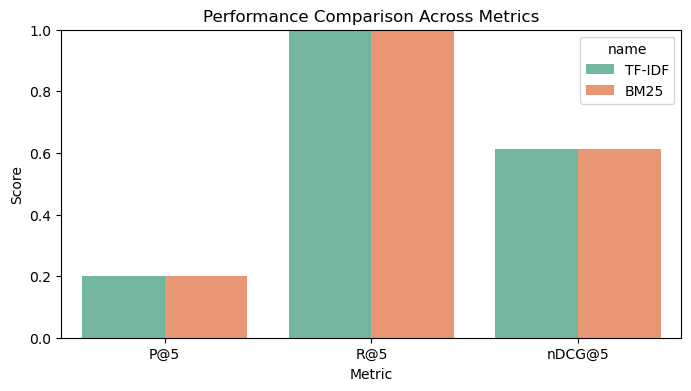

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

exp_melt = exp.melt(id_vars="name", var_name="Metric", value_name="Score")
plt.figure(figsize=(8,4))
sns.barplot(data=exp_melt, x="Metric", y="Score", hue="name", palette="Set2")
plt.title("Performance Comparison Across Metrics")
plt.ylim(0,1)
plt.show()

## Building the UI

In [21]:
!pip install python-terrier datasets nltk flask

  Using cached datasets-4.4.1-py3-none-any.whl.metadata (19 kB)
  Using cached flask-3.1.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached pyarrow-22.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
  Using cached xxhash-3.6.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
  Using cached multiprocess-0.70.18-py311-none-any.whl.metadata (7.5 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached typer_slim-0.20.0-py3-none-any.whl.metadata (16 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
Using cached datasets-4

In [48]:
from flask import Flask, request, render_template

In [114]:
# Initialize a new Flask web application
# Flask is a lightweight Python web framework ideal for demos
app = Flask(__name__)
username = os.environ.get("JUPYTERHUB_USER")
# app.config['APPLICATION_ROOT'] = f'/user/{username}/proxy/5000'

In [115]:
# Run this cell once to load the svg into the static directory for the favicon
svg_content = """
<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="currentColor" class="bi bi-search" viewBox="0 0 16 16">
  <path d="M11.742 10.344a6.5 6.5 0 1 0-1.397 1.398h-.001q.044.06.098.115l3.85 3.85a1 1 0 0 0 1.415-1.414l-3.85-3.85a1 1 0 0 0-.115-.1zM12 6.5a5.5 5.5 0 1 1-11 0 5.5 5.5 0 0 1 11 0"/>
</svg>
"""

with open("static/favicon.svg", "w") as f:
    f.write(svg_content.strip())

In [116]:
# Search endpoint: This route handles search requests like: /search?q=privacy
@app.route("/", methods=["GET"])
def search():
    query = request.args.get("q", "")
    results = None

    if query:
        res = bm25.search(query).head(5)
        results = []
        for _, row in res.iterrows():
            doc = df.loc[df["docno"] == row["docno"]].iloc[0]
            results.append({
                "rank": len(results) + 1,
                "docno": row["docno"],
                "snippet": doc["text"][:200],
                "score": round(row["score"], 3)
            })
            
    proxy_prefix = f"2025-autumn-info-376-a/user/{username}/proxy/5000"
    return render_template("index.html", results=results, query=query)

# Doc endpoint: This route handles get requests to view doc full text
@app.route("/doc/<docno>")
def display_doc(docno):
    doc = df.loc[df["docno"] == docno].iloc[0]
    proxy_prefix = f"2025-autumn-info-376-a/user/{username}/proxy/5000"
    return render_template("doc_view.html", docno=docno, full_text=doc["text"])


In [ ]:
# Run app (on jupyter server)
# username = os.environ.get("JUPYTERHUB_USER")
print("BM25 search ui running at:")
print(f"https://jupyter.rttl.uw.edu/2025-autumn-info-376-a/user/{username}/proxy/5000/")
app.run(host="0.0.0.0", port=5000, debug=False, use_reloader=False)

BM25 search ui running at:
https://jupyter.rttl.uw.edu/2025-autumn-info-376-a/user/laurak11/proxy/5000/
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.2.192.8:5000
Press CTRL+C to quit
127.0.0.1 - - [29/Nov/2025 00:27:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2025 00:27:37] "GET /?q=javascript HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2025 00:27:38] "GET /doc/javascript HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2025 00:28:04] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2025 00:28:08] "GET /?q=cdn HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2025 00:28:09] "GET /doc/cdn HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2025 00:28:11] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2025 00:28:15] "GET /?q=javascript HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2025 00:28:17] "GET /doc/javascript HTTP/1.1" 200 -
127.0.0.1 - - [29/Nov/2025 00:28:18] "GET / HTTP/1.1" 200 -
